In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

## Dataframe

In [2]:
df = pd.read_csv('Train.csv')
df

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


# STAGE 1

## 1. Data Exploration

### a. Memeriksa kolom dengan df.info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Kita dapat melihat bahwa:

1) Data memiliki 10999 baris dan 12 kolom.\
2) Target klasifikasinya adalah Reached.on.Time_Y.N, dinyatakan dalam nilai 0 dan 1. 0 = barang sampai dengan on time, 1 = barang tidak sampai dengan on time\
3) Tidak terdapat null value di semua kolom\
4) Selain kolom reached on time, bisa dibuat feature

In [4]:
numerics = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
categorical = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

### b. Summary dengan df.describe

In [5]:
df[numerics].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000


Kita bisa melihat bahwa\
1) Data **customer care calls**, **customer rating**, **cost of the product**, sepertinya memiliki distribusi normal, dilihat dari nilai median (50%) dekat dengan nilai mean, serta nilai median kira kira terletak di tengan Q1-Q3\
2) Tidak ada nilai yang negatif

Setelah dilakukan visualisasi sederhana di bawah ini, ternyata hanya customer care calls yang distribusinya mendekati normal

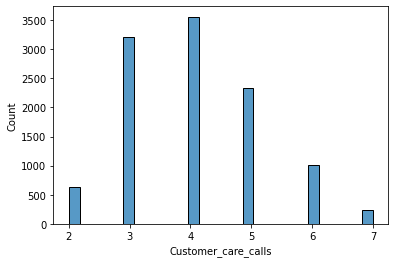

In [6]:
sns.histplot(data=df,x='Customer_care_calls');

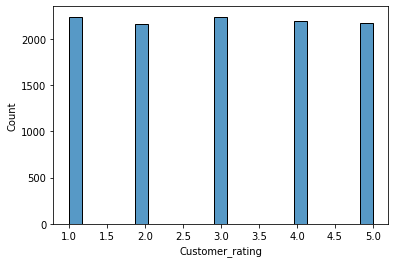

In [7]:
sns.histplot(data=df,x='Customer_rating');

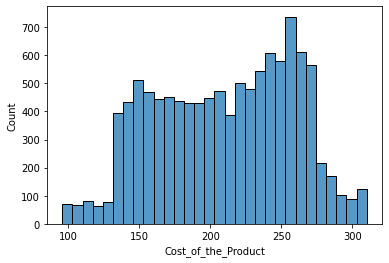

In [8]:
sns.histplot(data=df,x='Cost_of_the_Product');

In [9]:
df[categorical].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


Kita bisa melihat bahwa\
1) Moda transportasi yang digunakan paling banyak adalah Ship, pengguna terbanyak adalah Female, product importance terbanyak adalah 'low', barang paling banyak berasal dari warehouse block F\
2) Unique feature tidak terlalu banyak tiap kategori, jadi bisa digunakan langsung untuk klasifikasi

### c. Value counting per kategori 

In [10]:
for col in categorical:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom Warehouse_block:
F    3666
D    1834
C    1833
B    1833
A    1833
Name: Warehouse_block, dtype: int64

Value count kolom Mode_of_Shipment:
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64

Value count kolom Product_importance:
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64

Value count kolom Gender:
F    5545
M    5454
Name: Gender, dtype: int64



Seperti yang bisa dilihat, pengamatan kita dari df.describe() tadi terbukti benar.

warehouse_block paling banyak mengirim/menyimpan barang adalah block F, warehouse lain nya mengirim/menyimpan barang dengan jumlah yang sama


## 2. Data Cleansing

In [11]:
#Hilangkan data yang tidak penting seperti ID dan kolom Goals-nya
df_drop = df.drop(['ID'], axis=1)
df_drop.sample(5)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
8548,C,Ship,5,2,226,5,medium,M,5,1323,0
840,D,Ship,3,1,232,3,low,M,9,2958,1
1858,C,Ship,2,2,190,3,low,M,51,2380,1
3443,F,Ship,4,1,247,2,medium,F,7,5098,0
10843,F,Ship,4,1,154,2,low,M,1,5578,0


In [12]:
#Format penulisan kolom yang baru
df_drop.columns = ['WH_block', 'Mode_ship', 'Cust_call', 'Cust_rate', 'Cost_prod', 'Prev_purchase', 'Importance_prod', 'Gender', 'Discount', 'Weight', 'OnTime']

In [13]:
#Menyimpan kolom output dari data set 
saved = df['Reached.on.Time_Y.N']

In [14]:
#Mengelompokkan tipe data
numerics = ['Cust_call', 'Cust_rate', 'Cost_prod', 'Prev_purchase', 'Discount', 'Weight']
categorical = ['WH_block', 'Mode_ship', 'Importance_prod', 'Gender']

In [15]:
#Mengecek tipe data
df_drop

,WH_block,Mode_ship,Cust_call,Cust_rate,Cost_prod,Prev_purchase,Importance_prod,Gender,Discount,Weight,OnTime
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,C,Ship,5,4,242,5,low,F,4,1155,0
10997,F,Ship,5,2,223,6,medium,M,2,1210,0


Notes: Dari data diatas, diketahui bahwa data terdiri dari 7 data bertipe integer dan 4 data bertipe object

In [16]:
df_drop.isna().sum() #mengecek data yang null/kosong

WH_block           0
Mode_ship          0
Cust_call          0
Cust_rate          0
Cost_prod          0
Prev_purchase      0
Importance_prod    0
Gender             0
Discount           0
Weight             0
OnTime             0
dtype: int64

Notes: Dari data diatas, diketahui bahwa data yang bernilai null/NA tidak ada (tidak memiliki missing values)

In [17]:
#Mengecek data yang duplicate
print("Dari data yang disediakan, diketahui bahwa data yang duplicate adalah",df_drop.duplicated().sum())

Dari data yang disediakan, diketahui bahwa data yang duplicate adalah 0


### a. Korelasi data

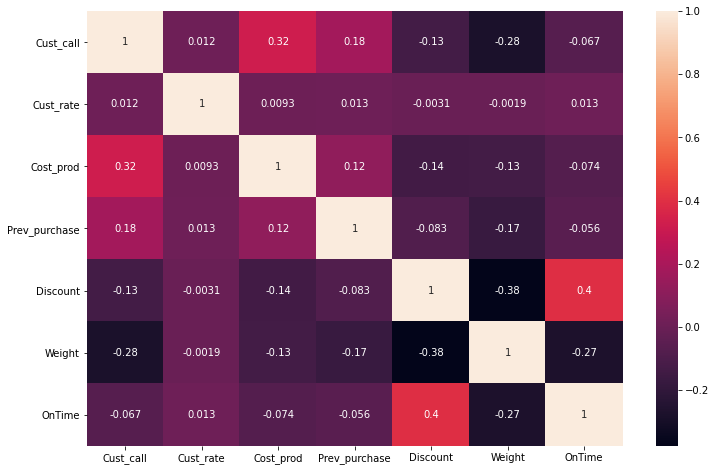

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df_drop.corr(), annot=True);

Pemilihan feature berdasarkan nilai korelasi pada heatmap, semakin kecil nilai di heatmap, feature semakin tidak mendukung pembuatan ML 

1. Hubungan antara `OnTime` dan `Weight`: Semakin berat barangnya semakin besar peluang dia untuk sampai tepat waktu.

2. Hubungan antara `Discount` dan `Weight`: Semakin kecil *discount*, semakin besar berat nya. Artinya, barang/produk yang dikirimkan namun memiliki berat yang berlebih (*overweight*) tidak mendapat banyak diskon

3. Hubungan antara `Discount` dan `OnTime`: Semakin besar discount, semakin besar kemungkinan barang itu tidak sampai. Jika dihubungkan dengan point No. 3 dan No. 1 artinya, Barang/Produk yang memiliki berat *overweight* akan mendapatkan *discount* yang besar namun cenderung tidak sampai tepat waktu

4. Hubungan antara `Cuss_call` dan `Cost_prod`: Semakin mahal barang yang dikirim, akan semakin banyak panggilan yang masuk ke perusahaan terkait pengiriman barang yang belum sampai

(MASUKAN)

Pemilihan Feature berdasarkan nilai korelasi heatmap dari kolom tujuan yaitu `OnTime` dengan kolom lain.
semakin kecil nilai *heatmap*, semakin tidak mendukung pembuatan ML.
  1. Hubungan `OnTime` dan `weight` : semakin berat suatu barang, semakin besar peluang barang itu sampai tepat waktu
  2. Hubungan `OnTime` dan `Discount` : semakin banyak diskon, semakin besar kemungkinan barang itu datang tepat waktu.

## 3. Feature Engineering

### a. Korelasi Data

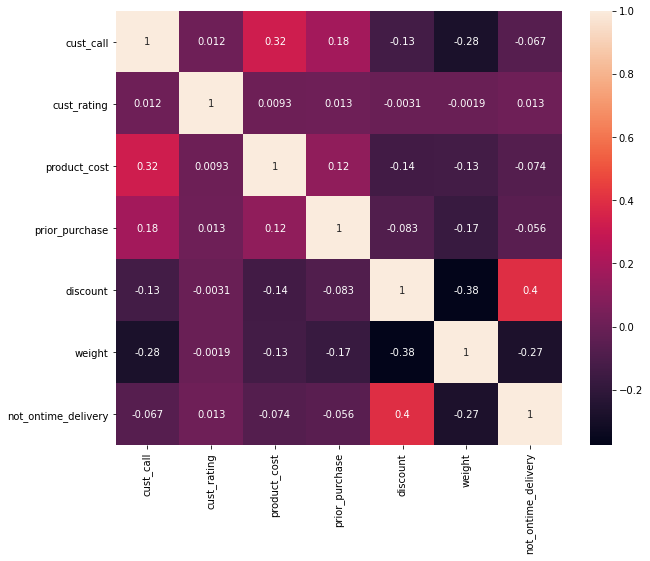

In [19]:
df = pd.read_csv('Train.csv')
df = df.drop(['ID'],axis=1)

df.columns = ['ware_block','mode_ship','cust_call','cust_rating','product_cost','prior_purchase','product_impt','gender','discount','weight','not_ontime_delivery']

df_num = ['cust_call','cust_rating','product_cost','prior_purchase','discount','weight']
df_cat = ['ware_block','mode_ship','product_impt','gender']

heatmap_corr = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(heatmap_corr,annot=True)
plt.show()

**Korelasi feature dengan variabel target**
- Discount memiliki korelasi (positif) paling tinggi dengan not_ontime delivery dengan koefesien korelasi 0.4
- Kedua berat barang atau weight memiliki korelasi (negatif) tertinggi kedua dengan koefesien korelasi -0.27
- Ke empat variabel lain product cost (-0.074), customer care call (-0.067), priority purchase (-0.056) dan customer rating (0.013) memiliki korelasi yang cenderung rendah dibawah 0.1

### b. Data Outliers

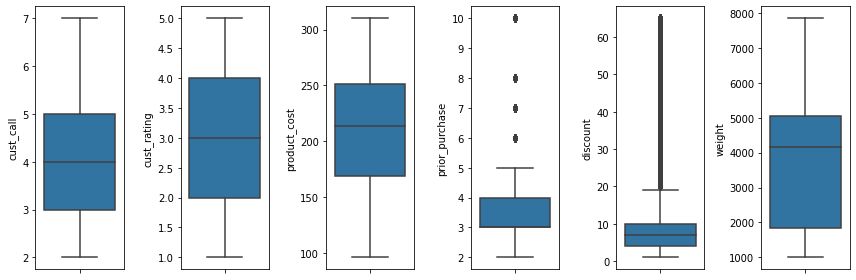

In [20]:
#Data include outlier

plt.figure(figsize = (12,4))
for i in range(0, len(df_num)):
    plt.subplot(1, 6, i+1)
    sns.boxplot(y = df[df_num[i]], orient='v')
    plt.tight_layout()

In [21]:
#Handling outliers

dfx = df.copy()

print(f'Jumlah baris sebelum memfilter outlier: {len(dfx)}')

fil_ent = np.array([True] * len(dfx))
for col in ['product_cost', 'discount','weight']:
    Q1 = dfx[col].quantile(0.25)
    Q3 = dfx[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    fil_ent = ((dfx[col] >= low_limit) & (dfx[col] <= high_limit)) & fil_ent
    
dfx = dfx[fil_ent].reset_index()

print('Jumlah baris setelah memfilter outlier', len(dfx))

Jumlah baris sebelum memfilter outlier: 10999
Jumlah baris setelah memfilter outlier 8790


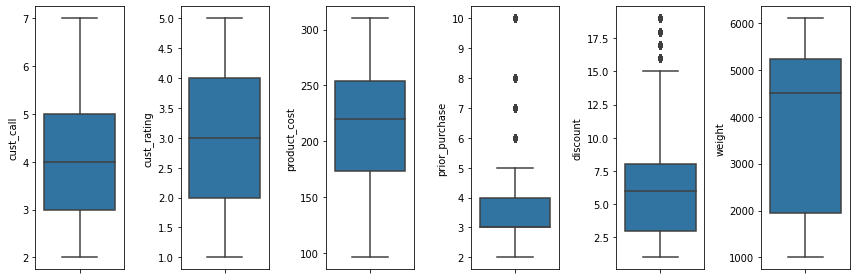

In [22]:
#Data setelah oulier dikeluarkan
plt.figure(figsize = (12,4))
for i in range(0, len(df_num)):
    plt.subplot(1, 6, i+1)
    sns.boxplot(y = dfx[df_num[i]], orient='v')
    plt.tight_layout()

### c. Normalisasi Data

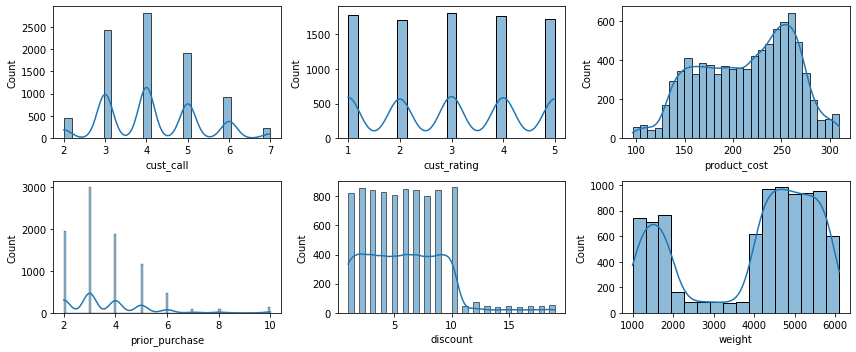

In [23]:
# Cek data sebelum di normalisasi
plt.figure(figsize = (12,5))
for i in range(0, len(df_num)):
    plt.subplot(2, 3, i+1)
    sns.histplot(dfx[df_num[i]], kde=True)
    plt.tight_layout()

In [24]:
#Normalisasi data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
dfx['product_cost_norm'] = MinMaxScaler().fit_transform(dfx['product_cost'].values.reshape(len(dfx), 1))
dfx['discount_norm'] = MinMaxScaler().fit_transform(dfx['discount'].values.reshape(len(dfx), 1))
dfx['weight_norm'] = MinMaxScaler().fit_transform(dfx['weight'].values.reshape(len(dfx), 1))


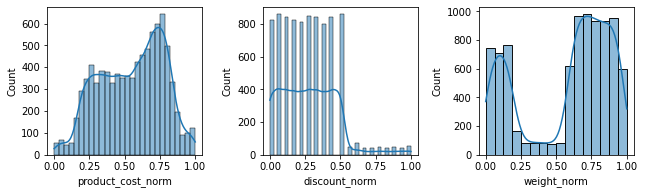

In [25]:
#Cek data setelah dinormalisasi
df_norm = ['product_cost_norm','discount_norm','weight_norm']

plt.figure(figsize = (12,5))
for i in range(0, len(df_norm)):
    plt.subplot(2, 4, i+1)
    sns.histplot(dfx[df_norm[i]], kde=True)
    plt.tight_layout()

In [26]:
#Drop variabel yang sudah di normalisasi
dfx.drop(['product_cost','discount','weight'], axis=1, inplace=True)

dfx.sample(5)

,index,ware_block,mode_ship,cust_call,cust_rating,prior_purchase,product_impt,gender,not_ontime_delivery,product_cost_norm,discount_norm,weight_norm
8034,10243,F,Ship,3,3,3,low,F,1,0.471963,0.166667,0.756126
1105,3314,A,Ship,6,4,2,high,M,0,0.336449,0.277778,0.918447
5026,7235,F,Road,3,4,3,medium,M,1,0.443925,0.277778,0.702803
2838,5047,F,Road,4,4,3,low,M,0,0.794393,0.166667,0.961380
4825,7034,A,Ship,4,2,3,low,M,1,0.752336,0.111111,0.891590


### d. Feature Encoding

In [27]:
#Cek count values di setiap variabel
print(df['ware_block'].value_counts(),'\n\n',df['mode_ship'].value_counts(),'\n\n',df['product_impt'].value_counts(),'\n\n',df['gender'].value_counts())

F    3666
D    1834
C    1833
B    1833
A    1833
Name: ware_block, dtype: int64 

 Ship      7462
Flight    1777
Road      1760
Name: mode_ship, dtype: int64 

 low       5297
medium    4754
high       948
Name: product_impt, dtype: int64 

 F    5545
M    5454
Name: gender, dtype: int64


In [28]:
# Cek jumlah columns
dfx.drop(['index'], axis=1, inplace=True)
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ware_block           8790 non-null   object 
 1   mode_ship            8790 non-null   object 
 2   cust_call            8790 non-null   int64  
 3   cust_rating          8790 non-null   int64  
 4   prior_purchase       8790 non-null   int64  
 5   product_impt         8790 non-null   object 
 6   gender               8790 non-null   object 
 7   not_ontime_delivery  8790 non-null   int64  
 8   product_cost_norm    8790 non-null   float64
 9   discount_norm        8790 non-null   float64
 10  weight_norm          8790 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 755.5+ KB


In [29]:
# Feature encoding
for cat in df_cat:
    onehots = pd.get_dummies(dfx[cat], prefix=cat)
    dfx = dfx.join(onehots)
dfx.info()

# Parameter n-1 feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ware_block           8790 non-null   object 
 1   mode_ship            8790 non-null   object 
 2   cust_call            8790 non-null   int64  
 3   cust_rating          8790 non-null   int64  
 4   prior_purchase       8790 non-null   int64  
 5   product_impt         8790 non-null   object 
 6   gender               8790 non-null   object 
 7   not_ontime_delivery  8790 non-null   int64  
 8   product_cost_norm    8790 non-null   float64
 9   discount_norm        8790 non-null   float64
 10  weight_norm          8790 non-null   float64
 11  ware_block_A         8790 non-null   uint8  
 12  ware_block_B         8790 non-null   uint8  
 13  ware_block_C         8790 non-null   uint8  
 14  ware_block_D         8790 non-null   uint8  
 15  ware_block_F         8790 non-null   u

In [30]:
#Drop feature awal yang sudah masuk proses feature encoding
dfx.drop(['ware_block','mode_ship','product_impt','gender'], axis=1, inplace=True)

In [31]:
dfx.sample(5)

,cust_call,cust_rating,prior_purchase,not_ontime_delivery,product_cost_norm,discount_norm,weight_norm,ware_block_A,ware_block_B,ware_block_C,ware_block_D,ware_block_F,mode_ship_Flight,mode_ship_Road,mode_ship_Ship,product_impt_high,product_impt_low,product_impt_medium,gender_F,gender_M
6132,6,4,4,0,0.883178,0.500000,0.082533,0,0,0,0,1,0,1,0,0,0,1,1,0
8201,4,3,5,0,0.640187,0.055556,0.015291,0,0,0,1,0,1,0,0,0,1,0,0,1
6906,3,4,3,0,0.705607,0.444444,0.859047,0,0,0,0,1,0,0,1,0,0,1,0,1
4642,4,1,3,0,0.359813,0.000000,0.930798,0,0,0,0,1,1,0,0,1,0,0,0,1
811,5,3,7,1,0.602804,0.888889,0.493041,0,0,0,1,0,0,0,1,0,0,1,1,0


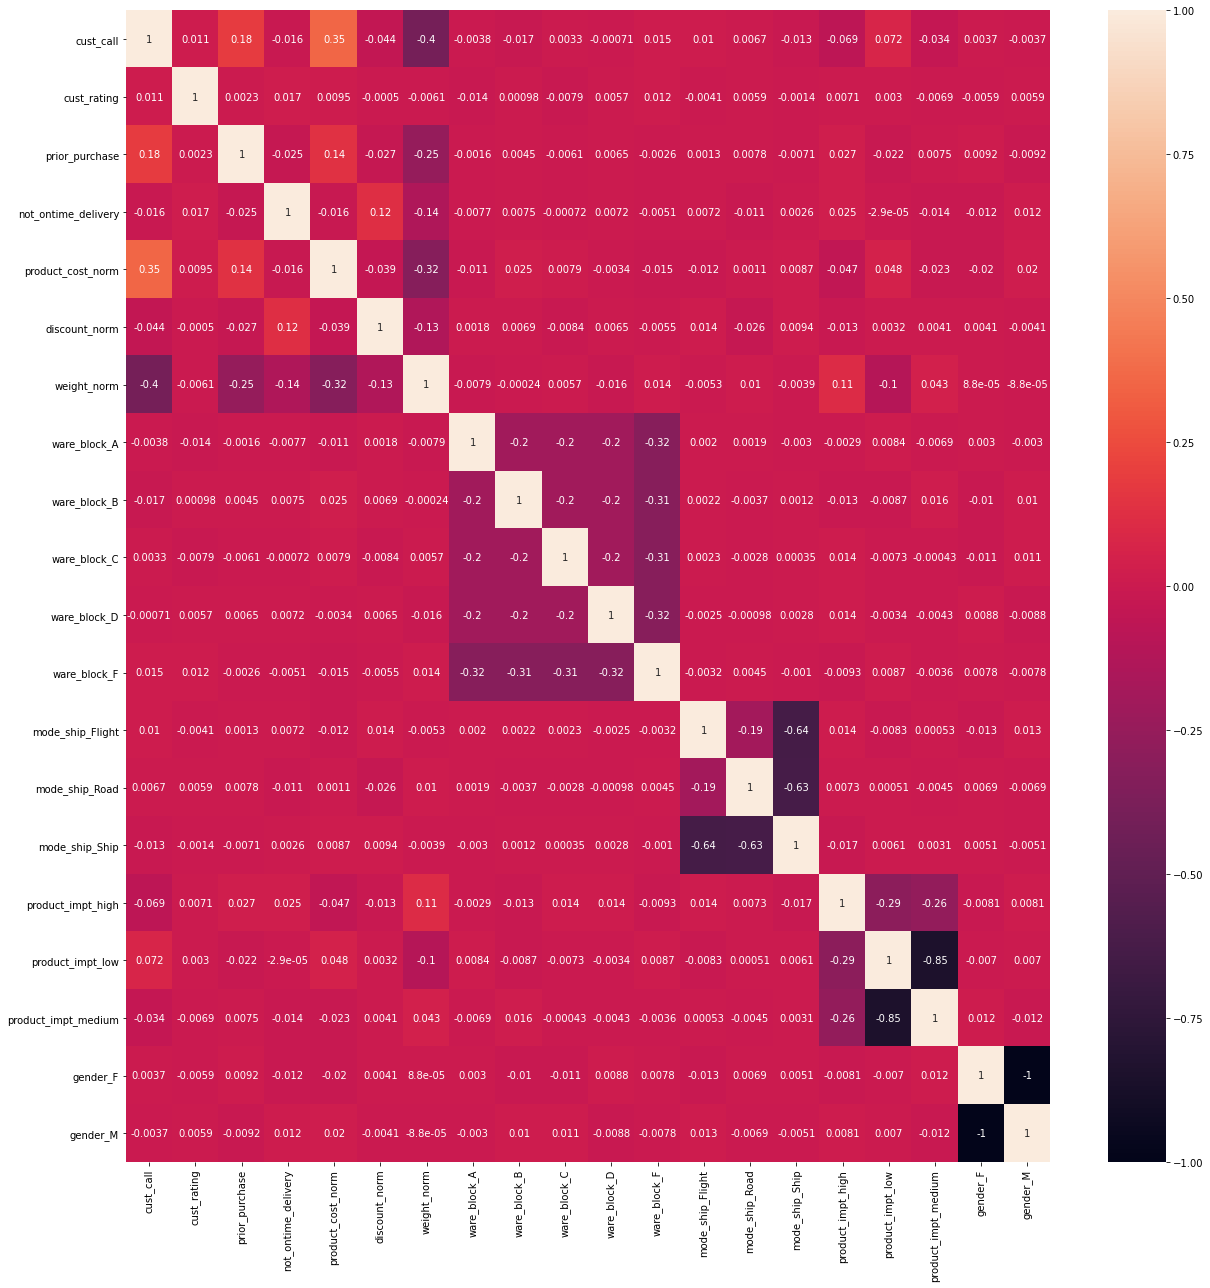

In [32]:
heatmap_corr = dfx.corr()
plt.figure(figsize = (18,18))
sns.heatmap(heatmap_corr,annot=True)
plt.tight_layout()

### e. Imbalance Sample

In [33]:
print(dfx['not_ontime_delivery'].value_counts())

0    4436
1    4354
Name: not_ontime_delivery, dtype: int64


# STAGE 2



## a) *Exploratory Data Analysis (EDA)*

### i) Analisis univariate

setelah melakukan data desctiptive, kita menganalisa dataset dengan analias univariate

### *Boxplot*

In [34]:
numerics = ['cust_call', 'cust_rating', 'product_cost_norm', 'prior_purchase', 'discount_norm', 'weight_norm']
categorical = ['WH_block', 'Mode_ship', 'Importance_prod', 'Gender']

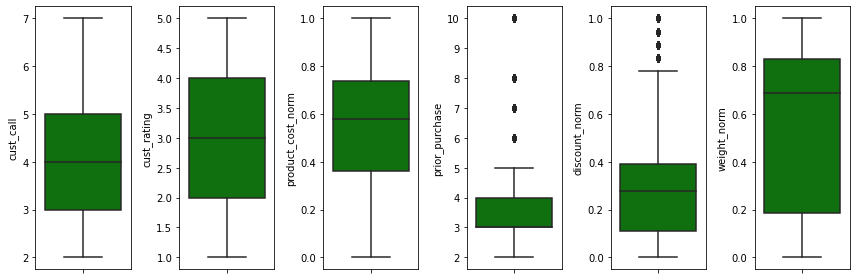

In [35]:
plt.figure(figsize=(12, 4))
for i in range(0, len(numerics)):
    plt.subplot(1, len(numerics), i+1)
    sns.boxplot(y=dfx[numerics[i]], color='green', orient='v')
    plt.tight_layout()

berdasarkan diagrab boxplot diatas dapat diartikan:

1. data yang memiliki nilai outlier adalah `Prev_purchase` dan `Discount`
2. data yang memiliki nial outlier nanti nya akan di adjust


### *Distplot*

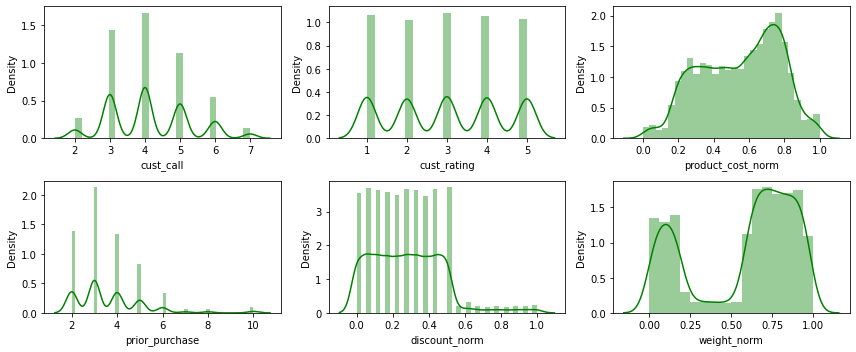

In [36]:
plt.figure(figsize=(12, 5))
for i in range(0, len(numerics)):
    plt.subplot(2, len(numerics)/2, i+1)
    sns.distplot(dfx[numerics[i]], color='green')
    plt.tight_layout()

Dari data di atas di simpulkan

1. Hampir tidak ada data yang skewed
2. Pada diagram `cust_rate` jumlah density(customer) pada rating 1 sampai 5 memiliki jumlah yang sama, perlu adanya *improvement* dari perusahaan agar rating 4 atau 5 memiliki jumlah density yang besar.

Question
1. apa penyebab rating 4 dan 5 tidak mempunyai density yang banyak?

### *Violin* *Plot*

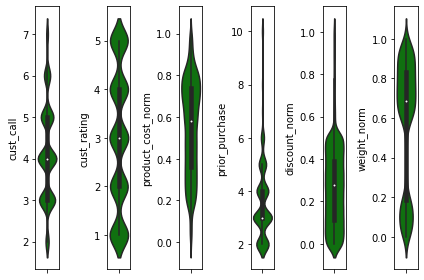

In [37]:
for i in range(0, len(numerics)):
    plt.subplot(1, len(numerics), i+1)
    sns.violinplot(y=dfx[numerics[i]], color='green', orient='v')
    plt.tight_layout()

alternative diagram untuk melihat insight bisa juga menggunakan violin plot

### ii) Analisis multivariat

## Correlation Heatmap

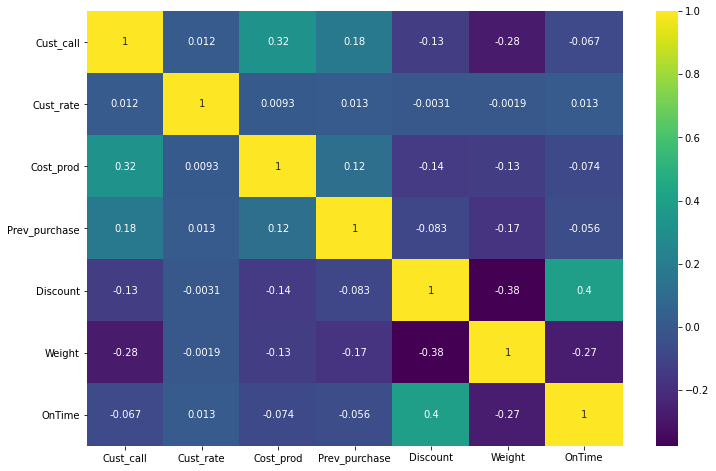

In [38]:
plt.figure(figsize=(12,8))
sns.heatmap(df_drop.corr(), cmap='viridis', annot=True);

Pemilihan feature berdasarkan nilai korelasi pada heatmap, semakin kecil nilai di heatmap, feature semakin tidak mendukung pembuatan ML 

*Insights*:
1. Hubungan antara `OnTime` dan `Weight`: Semakin berat barangnya semakin besar peluang dia untuk sampai tepat waktu.

2. Hubungan antara `Discount` dan `Weight`: Semakin kecil *discount*, semakin besar berat nya. Artinya, barang/produk yang dikirimkan namun memiliki berat yang berlebih (*overweight*) tidak mendapat banyak diskon

3. Hubungan antara `Discount` dan `OnTime`: Semakin besar discount, semakin besar kemungkinan barang itu tidak sampai. Jika dihubungkan dengan point No. 3 dan No. 1 artinya, Barang/Produk yang memiliki berat *overweight* akan mendapatkan *discount* yang besar namun cenderung tidak sampai tepat waktu

4. Hubungan antara `Cuss_call` dan `Cost_prod`: Semakin mahal barang yang dikirim, akan semakin banyak panggilan yang masuk ke perusahaan terkait pengiriman barang yang belum sampai

## Pair Plots (Numerics)

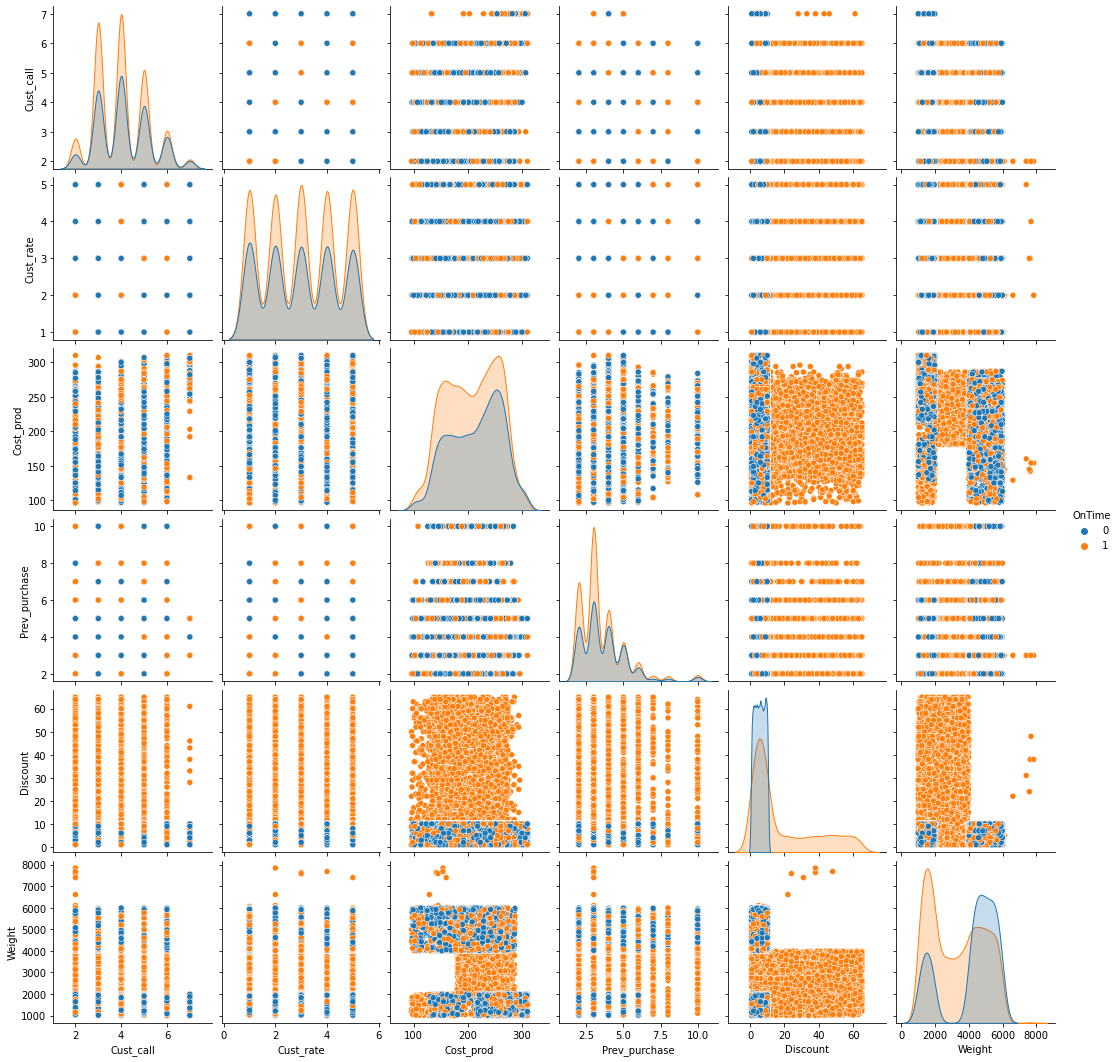

In [39]:
sns.pairplot(df_drop, diag_kind='kde', hue='OnTime');

In [113]:
dftest = df_drop.copy()
dftest['satisfaction'] = dftest['Cust_rate'].apply(lambda x: "Satisfaction" if x > 3 else 'Not Satisfaction')
dftest.reset_index().head()

,index,WH_block,Mode_ship,Cust_call,Cust_rate,Cost_prod,Prev_purchase,Importance_prod,Gender,Discount,Weight,OnTime,Perc_Disc,event,satisfaction
0,0,D,Flight,4,2,177,3,low,F,44,1233,1,0.248588,Bigsale ramadhan,Not Satisfaction
1,1,F,Flight,4,5,216,2,low,M,59,3088,1,0.273148,Bigsale ramadhan,Satisfaction
2,2,A,Flight,2,2,183,4,low,M,48,3374,1,0.262295,Bigsale ramadhan,Not Satisfaction
3,3,B,Flight,3,3,176,4,medium,M,10,1177,1,0.056818,Standard sale,Not Satisfaction
4,4,C,Flight,2,2,184,3,medium,F,46,2484,1,0.250000,Bigsale ramadhan,Not Satisfaction


In [132]:
test1 = dftest.groupby(['satisfaction', 'OnTime']).Gender.count().reset_index()
test1_pivot = test1.pivot(columns = 'satisfaction', index= 'OnTime', values='Gender').reset_index()
test1_pivot['percentage satisfaction (%)'] = test1_pivot['Satisfaction']/(test1_pivot['Satisfaction'] + test1_pivot['Not Satisfaction'])
test1_pivot['percentage not satisfaction (%)'] = test1_pivot['Not Satisfaction']/(test1_pivot['Satisfaction'] + test1_pivot['Not Satisfaction'])
test1_pivot

satisfaction,OnTime,Not Satisfaction,Satisfaction,percentage satisfaction (%),percentage not satisfaction (%)
0,0,2696,1740,0.392245,0.607755
1,1,3943,2620,0.399208,0.600792


(On Time) 40% customer satisfy - before
(On Time) 76% customer satisfy - after modelling

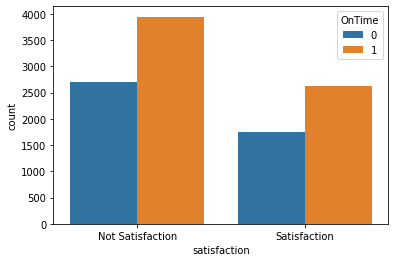

In [129]:
sns.countplot(data=dftest, x= 'satisfaction', hue='OnTime');

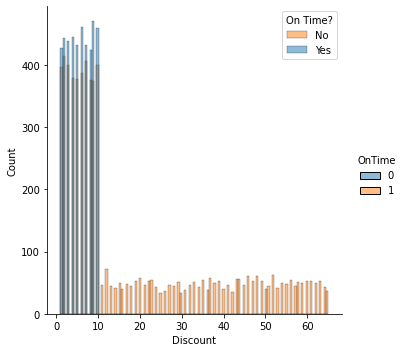

In [40]:
sns.displot(data = df_drop, x='Discount', hue='OnTime')
plt.legend(['No','Yes'], title = 'On Time?');

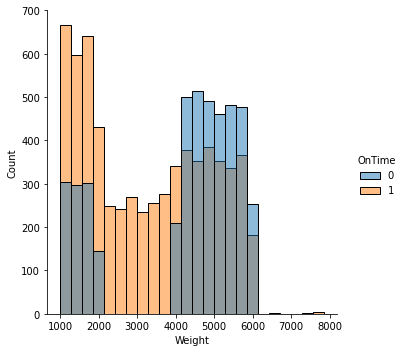

In [41]:
sns.displot(data=df_drop, x='Weight', hue='OnTime');

Scatter plot yang terpisah memberikan indikasi bahwa terdapat korelasi antar fitur yang cukup baik

*Insight*:
1. Dapat dilihat dari pairplot yang menegaskan Insight dari `heatmap` sebelumnya bahwa, semakin besar *discount* yang diberikan semakin besar kemungkinan untuk tidak sampai tepat waktu dan sebaliknya semakin kecil *discount* yang diberikan maka semakin besar kemungkinan untuk barang diantarkan tepat waktu
2. Sama seperti `heatmap` point diatas dapat dilihat bahwa untuk fitur *Weight*, semakin besar *Weight* barang yang dikirimkan semakin besar pula kemungkinan barang itu sampai dan begitu pula sebaliknya



Question:


1.   Kenapa barang yang lebih berat lebih berpotensi untuk sampai tepat waktu?
2.   Mengapa barang yang memiliki *Discount* yang lebih besar berpotensi tidak sampai tepat waktu?



## Category Plots (Categorical - Numerics)

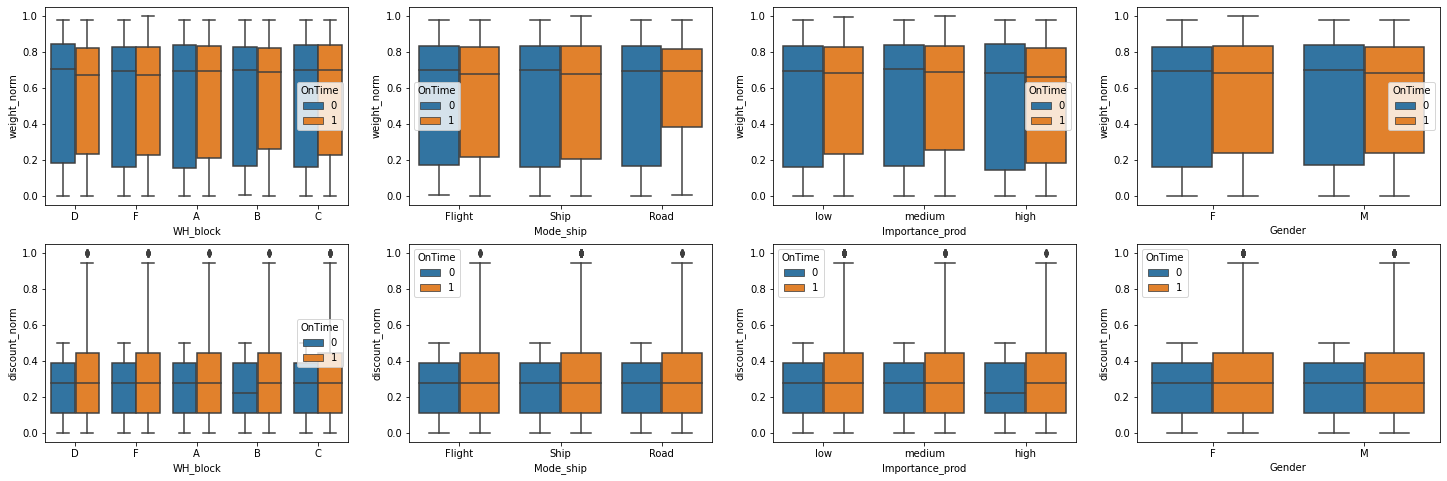

In [42]:
#Perbandingan antara data categorical dengan numerical(weight dan discount) dengan metode boxplot
fig, axes= plt.subplots(2, 4, figsize=(25, 8))
sns.boxplot(data= df_drop, x='WH_block', y=dfx['weight_norm'], ax=axes[0,0], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Mode_ship', y=dfx['weight_norm'], ax=axes[0,1], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Importance_prod', y=dfx['weight_norm'], ax=axes[0,2], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Gender', y=dfx['weight_norm'], ax=axes[0,3], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='WH_block', y=dfx['discount_norm'], ax=axes[1,0], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Mode_ship', y=dfx['discount_norm'], ax=axes[1,1], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Importance_prod', y=dfx['discount_norm'], ax=axes[1,2], hue=df_drop['OnTime']);
sns.boxplot(data= df_drop, x='Gender', y=dfx['discount_norm'], ax=axes[1,3], hue=df_drop['OnTime']);

## b) *Insights* dan Visualisasi Data

### Quest 1 : Bagaimana persebaran prosentase discount ? apa insight yang bisa diambil didalamnya ?


<Figure size 720x576 with 0 Axes>

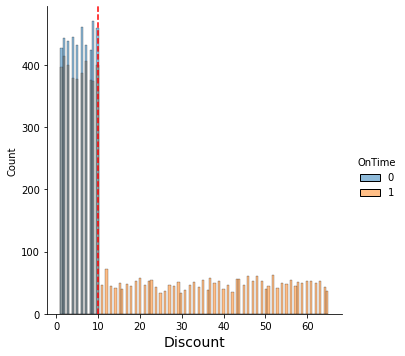

In [43]:
df_drop['Perc_Disc'] =  df_drop['Discount']/df_drop['Cost_prod'];

plt.figure(figsize=(10,8));
#sns.distplot(df_drop['Perc_Disc'])
sns.displot(data = df_drop, x='Discount', hue='OnTime');

plt.axvline(10, linestyle='--', color='red');
#plt.title('Most shipment have discount below 10%', fontsize=18, fontweight='bold');
plt.xlabel('Discount', fontsize=14);
#fig.legend(*ax.get_legend_handles_labels(), frameon=False)
#plt.text(0.2, 10, s='We should look deeper to Ontime status \nwho have discount below 10%',fontsize=16);

**Insight:** <br>
Peresebaran variabel presentase discount kebanyakan berada dibawah 10%, maka dari itu perlu dilakukan pengembangan untuk mengetahui bagaimana pengaruhnya terhadap ketepatan/keterlambatan pengiriman. maka dari itu pada quest 2 kami membuat asumsi dengan menambah variabel `event` seperti dibawah

### Quest 2 : Apakah barang yang dikirim dalam event big sale ramadhan akan cenderung datang tidak tepat waktu ?

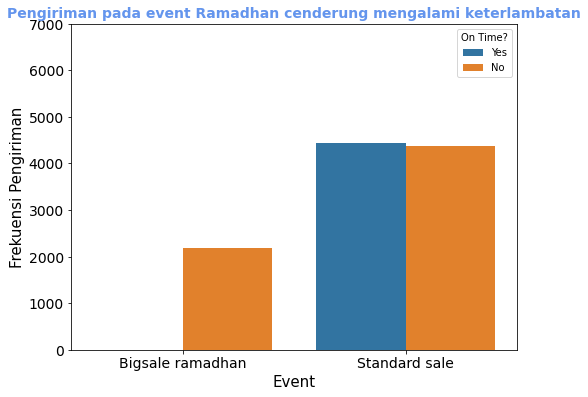

In [44]:
df_drop['event'] = df_drop['Perc_Disc'].apply(lambda x : 'Standard sale' if x<=0.10 else 'Bigsale ramadhan')

plt.figure(figsize=(8,6))
sns.countplot(x='event', hue='OnTime', data=df_drop)

plt.title('Pengiriman pada event Ramadhan cenderung mengalami keterlambatan',color='cornflowerblue',fontsize=14,fontweight='bold')
plt.ylabel('Frekuensi Pengiriman', fontsize=15) # y axis label
plt.xlabel('Event', fontsize=15) # x axis label
plt.ylim(0,7000)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(['Yes','No'], title = 'On Time?');

**Insight:** <br>
Dari barplot diatas dapat dilihat bahwa barang-barang yang dikirim hasil dari event bigsale ramadhan akan mengalami keterlambatan, hal ini sangat memungkinkan terjadi karena pada saat bigsale, terbanyak barang yang di checkout oleh customer sehingga terjadi overload dalam proses pengiriman

### Quest 3: Apakah sistem pengkategorian Product Importance berpengaruh terhadap sampainya barang dengan tepat waktu?

Sistem pengkategorian berdasarkan Product Importance bermanfaat ketika terjadi overload dalam shipping, di mana diperlukan sistem prioritas pengiriman barang, atau company memberi opsi pengiriman dengan fee lebih tinggi dan pengiriman lebih cepat. Ekspektasinya, barang dengan prioritasnya lebih tinggi memiliki kemungkinan untuk sampai tepat waktu juga tinggi, atau relatif tinggi dibanding dengan barang dengan prioritasnya lebih rendah.

In [45]:
# Tabel probabilitas Reach on Time dari setiap Product Importance
df = pd.read_csv('Train.csv')
dfq3 = df.groupby(['Product_importance','Reached.on.Time_Y.N'])['ID'].count().unstack()
dfq3 = dfq3.apply(lambda x: x*100/sum(x), axis=1)
dfq3.rename(columns={0:'Yes',1:'No'},inplace=True)
dfq3

Reached.on.Time_Y.N,Yes,No
Product_importance,,
high,35.021097,64.978903
low,40.721163,59.278837
medium,40.954985,59.045015


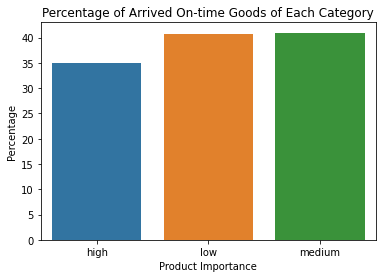

In [46]:
dfq3plot = dfq3.reset_index()
sns.barplot(x="Product_importance",y='Yes',data=dfq3plot)
plt.title('Percentage of Arrived On-time Goods of Each Category')
plt.xlabel('Product Importance')
plt.ylabel('Percentage');

Bisa dilihat bahwa:\
1) Justru barang yang importance nya 'high', kemungkinan barang sampai tepat waktunya paling rendah.\
2) Probabilitas barang sampai tepat waktu maksimal hanya sekitar 40%.\
2) Tidak ada perbedaan antara 'low' dan 'medium.


---


Artinya, sistem pengkategorian ini tidak efektif untuk memprioritaskan barang agar sampai tepat waktu. Ini menyebabkan customer satisfaction turun dengan beberapa kemungkinan, salah satunya:\
1) Customer tidak mau memakai jasa ini lagi, karena tidak ada jaminan barang sampai tepat waktu dengan memuaskan.\
2) Customer memilih menggunakan jasa dengan prioritas lebih rendah, karena prioritas barang lebih tinggi tidak menjamin barang akan sampai lebih tepat waktu.\
Semua ini menyebabkan revenue company turun.


---


**Feedback**: Secara umum, company harus memperbaiki sistem shipping ini agar probabilitas barang sampai tepat waktu lebih memuaskan. Company harus bisa memprioritaskan pengiriman dengan Product Importance yang lebih tinggi.

### Quest 4: Bagaimanakah distribusi Mode of Shipment dari setiap Warehouse block? Moda tranportasi apakah yang paling optimal dari setiap block?

Hal ini penting untuk mengetahui apakah memang ada pengaruh moda transportasi yang digunakan di setiap block terhadap probabilitas barang sampai tepat waktu. Selain itu, insight ini juga menunjukkan transportasi apa yang paling bisa diandalkan  dan mengidentifikasi transportasi apa yang perlu di-*improve* dari setiap block warehouse.

In [47]:
#Tabel persentase
dfq7 = df.groupby(['Warehouse_block', 'Mode_of_Shipment','Reached.on.Time_Y.N'])['ID'].count().unstack()
dfq7_percent = dfq7.apply(lambda x: x*100/sum(x), axis=1) #ubah value menjadi persentase
dfq7_percent.rename(columns={0:'Yes',1:'No'},inplace=True)
dfq7_percent

Reached.on.Time_Y.N                     Yes         No
Warehouse_block Mode_of_Shipment                      
A               Flight            41.414141  58.585859
                Road              42.857143  57.142857
                Ship              40.982287  59.017713
B               Flight            40.202703  59.797297
                Road              41.496599  58.503401
                Ship              39.259855  60.740145
C               Flight            37.627119  62.372881
                Road              42.517007  57.482993
                Ship              40.434084  59.565916
D               Flight            40.067340  59.932660
                Road              40.410959  59.589041
                Ship              40.240964  59.759036
F               Flight            39.864865  60.135135
                Road              39.931741  60.068259
                Ship              40.273312  59.726688

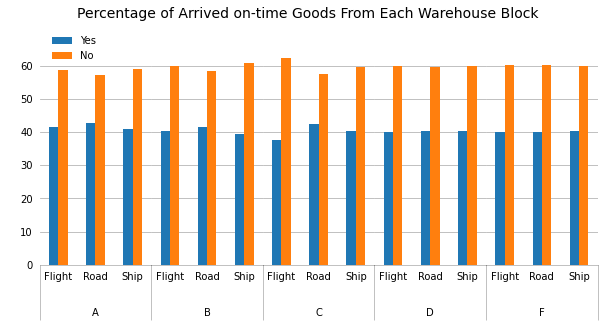

In [48]:
# Create figure with a subplot for each warehouse blocks with a relative width
# proportionate to the number of blocks
zones = dfq7_percent.index.levels[0]
nplots = zones.size
plots_width_ratios = [dfq7_percent.xs(zone).index.size for zone in zones]
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(10, 4),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each warehouse blocks
alpha = 0.3 # used for grid lines, bottom spine and separation lines between blocks
for zone, ax in zip(zones, axes):
    # Create bar chart with grid lines and no spines except bottom one
    dfq7_percent.xs(zone).plot.bar(ax=ax, legend=None, zorder=2)
    ax.grid(axis='y', zorder=1, color='black', alpha=alpha)
    for spine in ['top', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_alpha(alpha)
    
    # Set and place x labels for warehouse blocks
    ax.set_xlabel(zone)
    ax.xaxis.set_label_coords(x=0.5, y=-0.2)
    
    # Format major tick labels for factory names: note that because this figure is
    # only about 10 inches wide, I choose to rewrite the long names on two lines.
    ticklabels = [name.replace(' ', '\n') if len(name) > 10 else name
                  for name in dfq7_percent.xs(zone).index]
    ax.set_xticklabels(ticklabels, rotation=0, ha='center')
    ax.tick_params(axis='both', length=0, pad=7)
    
    # Set and format minor tick marks for separation lines between blocks: note
    # that except for the first subplot, only the right tick mark is drawn to avoid
    # duplicate overlapping lines so that when an alpha different from 1 is chosen
    # (like in this example) all the lines look the same
    if ax.is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)
    ax.tick_params(which='minor', length=55, width=0.8, color=[0, 0, 0, alpha])

# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(), frameon=False, loc=(0.08, 0.8))
fig.suptitle('Percentage of Arrived on-time Goods From Each Warehouse Block ', y=1.02, size=14);

Bisa dilihat bahwa:\
1) Probabilitas barang sampai dengan on time dari setiap block sekitar 40%\
2) Ada perbedaan dari setiap transportasi di suatu block, tetapi tidak signifikan.

---
Artinya, tidak ada moda transportasi yang optimal digunakan dari setiap block, karena tidak ada perbedaan yang signifikan (dari tabel, perbedaan hanya sekitar 1-5%).
Insight ini menunjukkan bahwa penyebab rendahnya kemungkinan barang sampai dengan on-time bukanlah dari warehouse block, maupun moda transportasi.


# STAGE 3

## 1. Logistic Regression

Pada model ini, nilai yang dianggap sebagai positive adalah 1 (TELAT). Oleh karena itu, nilai confusion matrix dimaknai sebagai berikut

1. True Positive (Realita TELAT, Prediksi TELAT)
2. True Negative (Realita ON-TIME, Prediksi ON-TIME)
1. False Negative (Realita TELAT, Prediksi ON-TIME)
2. False Positive (Realita ON-TIME, Prediksi TELAT)

Pada kasus ini, yang ingin diminimalkan adalah False Negative, karena sebisa mungkin menghindari salah prediksi barang yang kenyataannya telat. Oleh karena itu, nilai evaluasi model difokuskan untuk mengurangi False Negative ini, yaitu nilai Recall.

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

### a. Feature selection

Berdasarkan hasil heatmap, terlihat bahwa feature numerik yang paling berkorelasi kuat dengan target adalah Weight dan Discount. Namun, feature kategorikal yang dapat digunakan untuk model cukup membingungkan (tidak terlihat pemisahan unique feature yang jelas di categorical plots). Oleh karena itu. pada percobaan model ini, diuji 4 kombinasi feature terlebih dahulu.\
1) Weight + Discount + Warehouse block\
2) Weight + Discount + Mode of Shipment\
3) Weight + Discount + Product Importance\
4) Weight + Discount + Gender

Feature kategorikal yang paling bagus akan dikombinasikan dan diuji kembali

In [50]:
df_lr = dfx.copy()

# pakai dfx dari mas syahrul setelah dinormalisasi
# Line ini buat ganti nama kolom dulu kayak kolom mas amar, nanti kalo mas syahrul 
# udah ganti nama kolom di feature engineering, line ini bisa diapus.
df_lr.columns = ['Cust_call', 'Cust_rate', 'Prev_purchase', 'OnTime',
       'Cost_prod_norm', 'Discount_norm', 'Weight_norm',
       'WH_block_A', 'WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F',
       'Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
       'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium',
       'Gender_F', 'Gender_M']
# (template mas amar) df.columns = ['WH_block', 'Mode_ship', 'Cust_call', 'Cust_rate', 'Cost_prod', 'Prev_purchase', 'Importance_prod', 'Gender', 'Discount', 'Weight', 'OnTime']

df_lr.drop(['Cust_call', 'Cust_rate', 'Prev_purchase'], axis=1, inplace=True)
df_lr

,OnTime,Cost_prod_norm,Discount_norm,Weight_norm,WH_block_A,WH_block_B,WH_block_C,WH_block_D,WH_block_F,Mode_ship_Flight,Mode_ship_Road,Mode_ship_Ship,Importance_prod_high,Importance_prod_low,Importance_prod_medium,Gender_F,Gender_M
0,1,0.373832,0.500000,0.034503,0,1,0,0,0,1,0,0,0,0,1,0,1
1,1,0.308411,0.611111,0.081553,0,0,0,0,1,1,0,0,0,0,1,1,0
2,1,0.719626,0.111111,0.268575,0,0,0,1,0,1,0,0,0,1,0,1,0
3,1,0.252336,0.555556,0.168594,1,0,0,0,0,1,0,0,0,1,0,1,0
4,1,0.434579,0.611111,0.369927,0,0,1,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,1,0.728972,0.000000,0.105273,1,0,0,0,0,0,0,1,0,0,1,1,0
8786,0,0.635514,0.277778,0.048226,0,1,0,0,0,0,0,1,0,0,1,1,0
8787,0,0.682243,0.166667,0.030190,0,0,1,0,0,0,0,1,0,1,0,1,0
8788,0,0.593458,0.055556,0.040972,0,0,0,0,1,0,0,1,0,0,1,0,1


##### 1) Weight + Discount + Warehouse Block

In [51]:
# Split Feature and Label
X = df_lr.drop(columns=['Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
       'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium',
       'Gender_F', 'Gender_M','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [52]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [53]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.55
Recall (Test Set): 0.53
F1-Score (Test Set): 0.54
AUC: 0.56


In [54]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5512758004225581
Test score:0.558589306029579


##### 2) Weight + Discount + Mode of Shipment

In [55]:
# Split Feature and Label
X = df_lr.drop(columns=['WH_block_A','WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F',
                        'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium',
                        'Gender_F', 'Gender_M','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [56]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [57]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.55
Recall (Test Set): 0.53
F1-Score (Test Set): 0.54
AUC: 0.56


In [58]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5490004875670405
Test score:0.5601061812665908


##### 3) Weight + Discount + Product Importance



In [59]:
# Split Feature and Label
X = df_lr.drop(columns=['WH_block_A','WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F', 
                        'Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
                        'Gender_F', 'Gender_M','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [60]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [61]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.55
Recall (Test Set): 0.53
F1-Score (Test Set): 0.54
AUC: 0.56


In [62]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5535511132780757
Test score:0.5627607129313614


##### 4) Weight + Discount + Gender







In [63]:
# Split Feature and Label
X = df_lr.drop(columns=['WH_block_A','WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F', 
                        'Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
                        'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [64]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [65]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.55
Recall (Test Set): 0.52
F1-Score (Test Set): 0.54
AUC: 0.56


In [66]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5511132780757354
Test score:0.5612438376943496


##### 5) Kombinasi 3 kategorikal

Hasil kombinasi di atas menunjukkan bahwa kombinasi Weight + Discount dengan Warehouse Block, Mode of Shipment, dan Product Importance memiliki nilai Recall yang paling tinggi, sehingga pada section ini diuji kombinasi Weight + Discount + Warehouse + Mode of Shipment + Product Importance.

In [67]:
# Split Feature and Label
X = df_lr.drop(columns=['Gender_F', 'Gender_M','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [68]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [69]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.57
Precision (Test Set): 0.55
Recall (Test Set): 0.54
F1-Score (Test Set): 0.55
AUC: 0.57


In [70]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5519258898098488
Test score:0.5673113386423967


##### 6) Kombinasi 4 kategorikal

In [71]:
# Split Feature and Label
X = df_lr.drop(columns=['OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [72]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [73]:
# Evaluation
eval_classification(model_lr, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.55
Recall (Test Set): 0.53
F1-Score (Test Set): 0.54
AUC: 0.56


In [74]:
print('Train score: ' + str(model_lr.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_lr.score(X_test, y_test))) #accuracy

Train score: 0.5566390378677069
Test score:0.558968524838832


Nilai Recall kombinasi 4 kategorikal lebih rendah dari kombinasi 3 kategorikal.

### b. Hyperparameter tuning

Kombinasi feature terbaik adalah kombinasi antara Weight + Discount + Warehouse block + Mode of Shipment + Product Importance

In [75]:
# Split Feature and Label
X = df_lr.drop(columns=['Gender_F', 'Gender_M','OnTime'], axis=1)
y = df_lr['OnTime'] # target / label

#Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [76]:
# Logistic regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Prediction result
y_pred = model_lr.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [77]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002,0.00001] # Inverse of regularization strength; smaller values specify stronger regularization.
#solver=['saga']
hyperparameters = dict(penalty=penalty, C=C)


# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan RandomizedSearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.54
Precision (Test Set): 0.51
Recall (Test Set): 0.75
F1-Score (Test Set): 0.61
AUC: 0.54


In [78]:
print('Best algorithm:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best algorithm: l2
Best C: 1e-05


In [79]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.7400064998375041
Test score:0.7541111981205951


### d. Kesimpulan hasil modelling dengan Logistic Regression

Hasil modelling dengan metode Logistic Regression diperoleh nilai Recall terbaik sebesar 0,75 dan Accuracy 0,54.

## 2. K-Nearest Neighbors (K-NN)

Akan ada 2 percobaan:

1.   Melakukan modelling menggunakan KNN dengan semua fitur
2.   Melakukan modelling menggunakan KNN dengan fitur numerics (discount dan weight) dan semua fitur categorical



In [80]:
df = pd.read_csv('Train.csv')
df.drop('ID', axis= 1, inplace=True)
df.columns = ['ware_block','mode_ship','cust_call','cust_rating','product_cost','prior_purchase','product_impt','gender','discount','weight','not_ontime_delivery']

df_num = ['cust_call','cust_rating','product_cost_norm','prior_purchase','discount_norm','weight_norm']
df_cat = ['ware_block','mode_ship','product_impt','gender']
df.head()

,ware_block,mode_ship,cust_call,cust_rating,product_cost,prior_purchase,product_impt,gender,discount,weight,not_ontime_delivery
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [81]:
#Normalisasi data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df['product_cost_norm'] = MinMaxScaler().fit_transform(df['product_cost'].values.reshape(len(df), 1))
df['discount_norm'] = MinMaxScaler().fit_transform(df['discount'].values.reshape(len(df), 1))
df['weight_norm'] = MinMaxScaler().fit_transform(df['weight'].values.reshape(len(df), 1))
#Drop variabel yang sudah di normalisasi
df.drop(['product_cost','discount','weight'], axis=1, inplace=True)

df.sample(5)

,ware_block,mode_ship,cust_call,cust_rating,prior_purchase,product_impt,gender,not_ontime_delivery,product_cost_norm,discount_norm,weight_norm
7756,C,Ship,7,3,4,medium,M,1,0.822430,0.093750,0.009642
2372,A,Ship,2,3,3,low,M,1,0.154206,0.765625,0.016070
4915,F,Road,3,2,3,medium,M,0,0.728972,0.093750,0.512199
276,D,Flight,4,2,3,low,F,1,0.186916,1.000000,0.140394
10128,D,Road,5,2,4,high,M,0,0.158879,0.046875,0.492330


In [82]:
# Feature encoding
for cat in df_cat:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)
#Drop feature awal yang sudah masuk proses feature encoding
df.drop(['ware_block','mode_ship','product_impt','gender'], axis=1, inplace=True)
# Parameter n-1 feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cust_call            10999 non-null  int64  
 1   cust_rating          10999 non-null  int64  
 2   prior_purchase       10999 non-null  int64  
 3   not_ontime_delivery  10999 non-null  int64  
 4   product_cost_norm    10999 non-null  float64
 5   discount_norm        10999 non-null  float64
 6   weight_norm          10999 non-null  float64
 7   ware_block_A         10999 non-null  uint8  
 8   ware_block_B         10999 non-null  uint8  
 9   ware_block_C         10999 non-null  uint8  
 10  ware_block_D         10999 non-null  uint8  
 11  ware_block_F         10999 non-null  uint8  
 12  mode_ship_Flight     10999 non-null  uint8  
 13  mode_ship_Road       10999 non-null  uint8  
 14  mode_ship_Ship       10999 non-null  uint8  
 15  product_impt_high    10999 non-null 

In [83]:
df_knn = df.copy()
df_knn.columns = ['Cust_call', 'Cust_rate', 'Prev_purchase', 'Not_On_Time',
                  'Cost_prod_norm', 'Discount_norm', 'Weight_norm', 'WH_block_A',
                  'WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F', 
                  'Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship', 
                  'Importance_prod_high', 'Importance_prod_low', 
                  'Importance_prod_medium', 'Gender_F', 'Gender_M']
#Fitur ini di drop karna tipe data numeric yang ordinal
df_knn.drop(['Cust_call', 'Cust_rate', 'Prev_purchase'], axis=1, inplace=True)
df_knn.head()

,Not_On_Time,Cost_prod_norm,Discount_norm,Weight_norm,WH_block_A,WH_block_B,WH_block_C,WH_block_D,WH_block_F,Mode_ship_Flight,Mode_ship_Road,Mode_ship_Ship,Importance_prod_high,Importance_prod_low,Importance_prod_medium,Gender_F,Gender_M
0,1,0.378505,0.671875,0.033893,0,0,0,1,0,1,0,0,0,1,0,1,0
1,1,0.560748,0.906250,0.304894,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0.406542,0.734375,0.346676,1,0,0,0,0,1,0,0,0,1,0,0,1
3,1,0.373832,0.140625,0.025712,0,1,0,0,0,1,0,0,0,0,1,0,1
4,1,0.411215,0.703125,0.216654,0,0,1,0,0,1,0,0,0,0,1,1,0


### Percobaan Pertama

In [84]:
#Menggunakan semua fitur kecuali fitur goals
x= df_knn.drop(columns=['Not_On_Time'])
y= df_knn['Not_On_Time']

#Split Data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.3, random_state = 42)

#Import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)

#Prediction Result
y_pred = knn.predict(xtest)
y_pred

array([1, 0, 0, ..., 1, 1, 1])

In [85]:
#Eval and scoring train and test data
eval_classification(knn, y_pred, xtrain, ytrain, xtest, ytest)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.71
Recall (Test Set): 0.67
F1-Score (Test Set): 0.69
AUC: 0.63


In [86]:
print('Train Score:', str(knn.score(xtrain, ytrain))) #accuracy
print('Test Score:', str(knn.score(xtest, ytest))) #accuracy

Train Score: 0.7725678659566177
Test Score: 0.6378787878787879


### Percobaan Kedua

In [87]:
x = df_knn.drop(columns=['Cost_prod_norm', 'Not_On_Time'], axis=1)
y = df_knn['Not_On_Time']

#Split Data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.3, random_state= 42) #Test Size best at 1/3

#Import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)

#Prediction Result
y_pred = knn.predict(xtest)
y_pred

array([1, 0, 0, ..., 1, 1, 1])

In [88]:
xtrain.shape

(7699, 15)

In [89]:
ytrain.shape

(7699,)

In [90]:
#Eval of Train and Test data
eval_classification(knn, y_pred, xtrain, ytrain, xtest, ytest)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.72
Recall (Test Set): 0.66
F1-Score (Test Set): 0.69
AUC: 0.64


In [91]:
print('Train Score:', str(knn.score(xtrain, ytrain))) #accuracy
print('Test Score:', str(knn.score(xtest, ytest))) #accuracy

Train Score: 0.7551630081828808
Test Score: 0.6415151515151515


Dari ke-2 percobaan di atas dapat disimpulkan bahwa kombinasi feature terbaik ada pada percobaan ke-1 dengan `recall 0.6`

Selanjutnya akan dilakukan Tuning Hyperparameter


In [92]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

In [93]:
#Menggunakan semua fitur kecuali fitur goals
x= df_knn.drop(columns=['Not_On_Time'])
y= df_knn['Not_On_Time']

#Split Data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.3, random_state = 42)

#Import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)

#Prediction Result
y_pred = knn.predict(xtest)
y_pred

array([1, 0, 0, ..., 1, 1, 1])

In [94]:
#Eval of Train and Test data
eval_classification(knn, y_pred, xtrain, ytrain, xtest, ytest)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.71
Recall (Test Set): 0.67
F1-Score (Test Set): 0.69
AUC: 0.63


In [95]:
#RandomozedSearchCV
n_neighbors = list(range(1,30))
p= [1, 2, 3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
hyperparameters = dict(n_neighbors = n_neighbors, p = p, algorithm = algorithm, weights = weights)

#Inisialisasi Model
knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, hyperparameters, cv = 5, random_state= 42, scoring='recall')

#Model and Eval
model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)
eval_classification(model, y_pred, xtrain, ytrain, xtest, ytest)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.71
Recall (Test Set): 0.69
F1-Score (Test Set): 0.70
AUC: 0.63


In [96]:
print('Train Score:', str(model.score(xtrain, ytrain))) #accuracy
print('Test Score:', str(model.score(xtest, ytest))) #accuracy

Train Score: 0.826448087431694
Test Score: 0.687625754527163


In [97]:
#Best parameter
print('Best n_neighbors:', model.best_estimator_.get_params()['n_neighbors'])
print('Best p:', model.best_estimator_.get_params()['p'])
print('Best algorithm:', model.best_estimator_.get_params()['algorithm'])
print('Best weights:', model.best_estimator_.get_params()['weights'])

Best n_neighbors: 3
Best p: 3
Best algorithm: brute
Best weights: uniform


## 3. Decision Tree

## Decision tree 1


In [98]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

X = df.drop(columns=['not_ontime_delivery'])
y = df['not_ontime_delivery'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.70
Recall (Test Set): 0.69
F1-Score (Test Set): 0.70
AUC: 0.63


## Decision Tree 2

In [99]:
X = df.drop(columns=['not_ontime_delivery','ware_block_C','mode_ship_Road','gender_M'])
y = df['not_ontime_delivery'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.70
Recall (Test Set): 0.71
F1-Score (Test Set): 0.71
AUC: 0.63


## Decision Tree 3

In [100]:
X = df.drop(columns=['not_ontime_delivery','ware_block_C','mode_ship_Road','gender_M','ware_block_D','ware_block_B','prior_purchase'])
y = df['not_ontime_delivery'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.71
Recall (Test Set): 0.70
F1-Score (Test Set): 0.71
AUC: 0.64


Dari 3 hasil decision tree di atas, didapatkan model decision tree 3 adalah model yang paling baik, ole karena itu kami memutuskan untuk membuat hyperparameter turning untuk memaksimalkan modelnya

## Tuning Hyperparameter model 3

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 20, num = 20)] # Maximum number of levels in tree
criterion = ['gini','entropy']
splitter = ['best','random']
min_samples_split = [int(x) for x in np.linspace(1, 100, num = 100)] # Minimum number of samples required to split a node
min_samples_leaf = [int(x) for x in np.linspace(1, 1100, num = 1100)] # Minimum number of samples required at each leaf node
max_features = ['auto','sqrt', 'log2'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth,
                       criterion=criterion,
                       splitter=splitter,
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

print('\nBest max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best Criterion:', model.best_estimator_.get_params()['criterion'])
print('Best Splitter:', model.best_estimator_.get_params()['splitter'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])

print('\nUnderfitting/overfitting check')
print('Train score: ' + str(model.score(X_train, y_train)))
print('Test score:' + str(model.score(X_test, y_test)))

Accuracy (Test Set): 0.60
Precision (Test Set): 0.60
Recall (Test Set): 1.00
F1-Score (Test Set): 0.75
AUC: 0.50

Best max_depth: 15
Best Criterion: gini
Best Splitter: random
Best min_samples_split: 60
Best min_samples_leaf: 843
Best max_features: sqrt

Underfitting/overfitting check
Train score: 1.0
Test score:1.0


Hasil check : Model termasuk fit, karena train score dan test score mempunyai akurasi yang hampir sama!

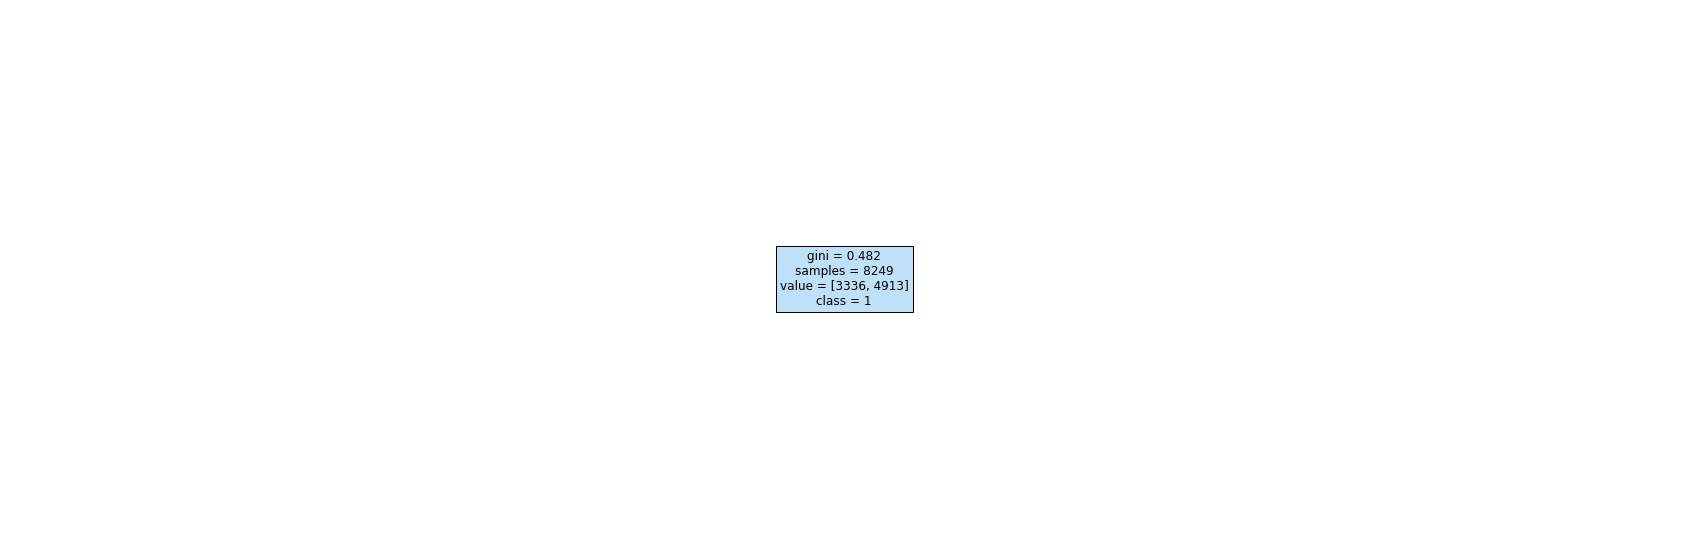

In [102]:
#Tree Check
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30, 10))
tree.plot_tree(model.best_estimator_,
               feature_names = X.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=7, fontsize=12)

plt.show()

Text(0.5, 1.0, 'feature importance score')

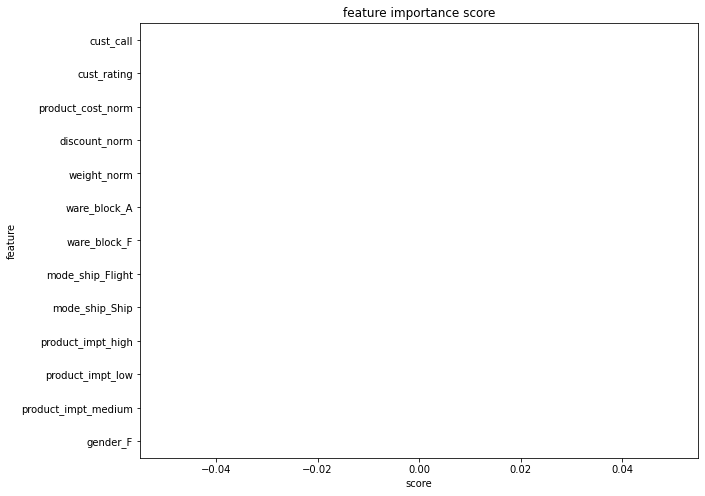

In [103]:
#Check Feature Importance
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

Conclusion: Model dari algoritma Decision tree menghasilkan recall sebesar 98%. Artinya barang 98% diprediksi akan datang terlambat berkaitan dengan variabel:

Berat barang yang dikirim (weight)
Harga barang (Product cost)
Tingkat kepentingan barang (Product importance)
Barang yang berasal dari gudang block A (warehouse block A)
Jenis pengiriman menggunakan kapal dan pesawat

## Ensamble method

In [104]:
df_EM = dfx.copy()
df_EM.columns = ['Cust_call', 'Cust_rate', 'Prev_purchase', 'OnTime',
       'Cost_prod_norm', 'Discount_norm', 'Weight_norm',
       'WH_block_A', 'WH_block_B', 'WH_block_C', 'WH_block_D', 'WH_block_F',
       'Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
       'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium',
       'Gender_F', 'Gender_M']

In [105]:

# Split Feature and Label
X = df_EM.drop(columns=['Mode_ship_Flight', 'Mode_ship_Road', 'Mode_ship_Ship',
       'Importance_prod_high', 'Importance_prod_low', 'Importance_prod_medium',
       'Gender_F', 'Gender_M','OnTime'], axis = 1)
y = df_EM['OnTime'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [106]:
df_EM.sample(5)

,Cust_call,Cust_rate,Prev_purchase,OnTime,Cost_prod_norm,Discount_norm,Weight_norm,WH_block_A,WH_block_B,WH_block_C,WH_block_D,WH_block_F,Mode_ship_Flight,Mode_ship_Road,Mode_ship_Ship,Importance_prod_high,Importance_prod_low,Importance_prod_medium,Gender_F,Gender_M
7611,4,2,2,1,0.303738,0.388889,0.912174,0,0,1,0,0,0,0,1,1,0,0,1,0
5327,2,5,4,1,0.780374,0.166667,0.596158,0,0,0,1,0,1,0,0,0,0,1,1,0
2002,4,3,2,0,0.224299,0.222222,0.760831,0,0,0,0,1,0,0,1,0,1,0,1,0
5872,5,4,3,1,0.214953,0.388889,0.875711,0,0,0,0,1,1,0,0,0,1,0,1,0
5978,3,1,4,1,0.570093,0.277778,0.878063,0,1,0,0,0,0,0,1,0,1,0,0,1


### [Ask] Metrics Evaluasi apa yang cocok diterapkan?
- Kita akan melakukan prediksi terhadap keterlambatan pengiriman, label 1 adalah 'pengiriman lambat', label 0 adalah pengiriman tepat waktu. 
- Metrics apa yang sebaiknya kita gunakan?

## Standart Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.55
Precision (Test Set): 0.53
Recall (Test Set): 0.56
F1-Score (Test Set): 0.55
AUC: 0.55


### Bagging: Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.59
Recall (Test Set): 0.50
F1-Score (Test Set): 0.54
AUC: 0.58


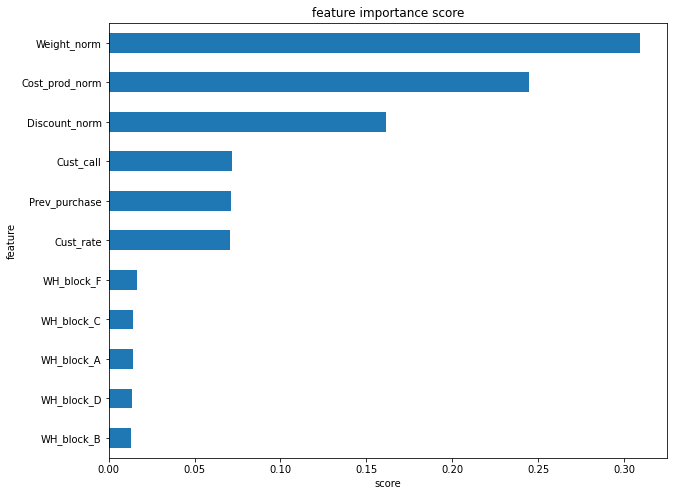

In [109]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')
    
show_feature_importance(rf)

### Hyperparameter tuning with RandomizedSearch

In [110]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned.predict(X_test)#Check performa dari model
eval_classification(rf_tuned, y_pred, X_train, y_train, X_test, y_test)

KeyboardInterrupt: ignored

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

y_pred = ab.predict(X_test)
eval_classification(ab, y_pred, X_train, y_train, X_test, y_test)

In [ ]:
show_feature_importance(ab)